In [92]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [105]:
import xarray as xr
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [94]:
eddies_train = xr.open_dataset('ocean-eddy-detection/eddies_train.nc')
X_train = xr.open_dataset('ocean-eddy-detection/OSSE_U_V_SLA_SST_train.nc')

In [95]:
y = eddies_train.eddies.values
X_verti = X_train.vomecrtyT.values
X_hori = X_train.vozocrtxT.values
X_SSH = X_train.sossheig.values
X_SST = X_train.votemper.values

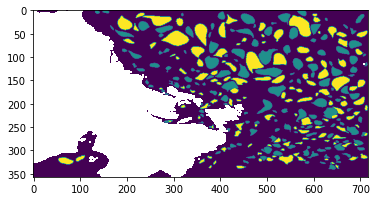

In [96]:
plt.imshow(y[0])

In [97]:
X = np.array([X_verti, X_hori, X_SSH, X_SST])
X = X.transpose((1,0,2,3))
X = np.nan_to_num(X, nan=-1000)
X = torch.tensor(X)
X.shape

torch.Size([284, 4, 357, 717])

In [98]:
y = np.nan_to_num(y, nan=-1)
y = torch.tensor(y)
y.shape

torch.Size([284, 357, 717])

In [101]:
class TrainDataset(Dataset):
    def __init__(self, path):

        eddies_train = xr.open_dataset(path + '/eddies_train.nc')
        X_train = xr.open_dataset(path + '/OSSE_U_V_SLA_SST_train.nc')
        y = eddies_train.eddies.values
        X_verti = X_train.vomecrtyT.values
        X_hori = X_train.vozocrtxT.values
        X_SSH = X_train.sossheig.values
        X_SST = X_train.votemper.values
        X = np.array([X_verti, X_hori, X_SSH, X_SST])
        X = X.transpose((1,0,2,3))
        X = np.nan_to_num(X, nan=-1000)
        self.X_train = torch.tensor(X)

    def __len__(self):
        return len(self.X_train)

    def __getitem__(self, idx):
        return self.X_train[idx], y[idx]

In [106]:
trainDataset = TrainDataset('ocean-eddy-detection')
train_dataloader = DataLoader(trainDataset, batch_size=64, shuffle=True)

In [ ]:
class Unet(nn.Module):
    """
    Our modified Unet :
    Use of padding to keep size of input in output easily.
    Use of batchnorm2d after Conv2d
    """
    def __init__(self):
        super().__init__()

        self.downblock1 = nn.Sequential(
            # nn.Dropout2d(0.2),
            nn.Conv2d(4, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.downblock2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(64, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.downblock3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),          
            nn.Conv2d(128, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.middleU = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            # nn.Dropout2d(0.2),
            nn.Conv2d(256, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2)
        )

        self.upblock1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        )

        self.upblock2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # nn.Dropout2d(0.2),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        )

        self.upblock3 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding='same', padding_mode='replicate'),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=1)
        )
    

    def forward(self, x):
        mask = (X[0][0]==-1000)
        
        x1 = self.downblock1(x)

        x2 = self.downblock2(x1)

        x3 = self.downblock3(x2)

        xmiddle = self.middleU(x3)

        xup0_1 = torch.cat((x3,xmiddle), dim=1)
        xup1 = self.upblock1(xup0_1)

        xup1_2 = torch.cat((x2,xup1), dim=1)
        xup2 = self.upblock2(xup1_2)

        xup2_3 = torch.cat((x1,xup2), dim=1)
        xup3 = self.upblock3(xup2_3)

        xup3[:,:, mask] = -1
        return xup3


In [ ]:
model = Unet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
model(X[0].reshape(1,4,357,717).to(device))

tensor([[ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])


tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -0.2017, -0.2345, -0.2282],
          [-1.0000, -1.0000, -1.0000,  ..., -0.1688, -0.2402, -0.2356],
          [-1.0000, -1.0000, -1.0000,  ..., -0.0981, -0.1487, -0.1423],
          ...,
          [-0.1073, -0.2064, -0.0293,  ..., -0.0677, -0.1986, -0.1629],
          [-0.1330, -0.1797, -0.1262,  ..., -0.1356, -0.1304, -0.1786],
          [-0.0441, -0.1668, -0.0866,  ..., -0.0810, -0.0826, -0.1109]],

         [[-1.0000, -1.0000, -1.0000,  ..., -0.0527, -0.0329,  0.0280],
          [-1.0000, -1.0000, -1.0000,  ..., -0.1036,  0.0327, -0.0129],
          [-1.0000, -1.0000, -1.0000,  ..., -0.0165, -0.0542, -0.0170],
          ...,
          [-0.0181, -0.0559,  0.0676,  ...,  0.0048, -0.0640, -0.0107],
          [-0.0658,  0.0324, -0.0019,  ..., -0.0517, -0.0132, -0.0013],
          [-0.0534, -0.0208, -0.0109,  ...,  0.0042,  0.0063, -0.0156]],

         [[-1.0000, -1.0000, -1.0000,  ...,  0.1450,  0.0985,  0.1351],
          [-1.0000, -1.0000, -

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")